In [1]:
#Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd;
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import os
import sys
import shutil
import keras
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from spektral.data.utils import to_tf_signature, prepend_none
from spektral.data import DisjointLoader, Dataset
from spektral.layers import GlobalMaxPool, GlobalAvgPool, GCSConv
from spektral.transforms import GCNFilter, NormalizeAdj
import scipy.sparse
from spektral.data.graph import Graph
from keras.layers import Dense, concatenate, Dropout
from keras import Model

In [2]:
features = pd.read_csv('thingi10k_data.csv', index_col=0)
adjpath = '../Data/stl/adjacency_stl_simplified/'
cloudpath = '../Data/stl/nodefeatures_stl_simplified/'
edgepath = '../Data/stl/edgefeaturesmatrix_stl_simplified/'

In [3]:
#Custom disjointloader
def getFeatures(batch):
    feats = []
    for graph in batch:
        feats.append(graph.__getattribute__('feats'))
    return np.array(feats)

class MyDisjointLoader(DisjointLoader):
    def __init__(
        self, dataset, node_level=False, batch_size=1, epochs=None, shuffle=True
    ):
        self.node_level = node_level
        super().__init__(dataset, batch_size=batch_size, epochs=epochs, shuffle=shuffle)

    def __next__(self):
        nxt = self._generator.__next__()
        feats = getFeatures(nxt)
        #feats = nxt[0].__getattribute__('feats')
        output, y = self.collate(nxt)
        feats = (feats,)
        output = output + feats
        return   output, y
    
    def tf_signature(self):
    
        signature = self.dataset.signature
        if "y" in signature:
            signature["y"]["shape"] = prepend_none(signature["y"]["shape"])
        if "a" in signature:
            signature["a"]["spec"] = tf.SparseTensorSpec

        signature["i"] = dict()
        signature["i"]["spec"] = tf.TensorSpec
        signature["i"]["shape"] = (None,)
        signature["i"]["dtype"] = tf.as_dtype(tf.int64)

        sig = (tf.TensorSpec(shape=[None,13]),)
        input = to_tf_signature(signature)
        sig = input[0] + sig
        return (sig, input[1])

In [4]:
#Read data, drop unnecessary
data = pd.read_csv('thingi10k_data.csv', index_col=0)

df = data.copy()
df.drop("source", axis=1, inplace=True)
df.drop("model_name", axis=1, inplace=True)

#Extract build times
build_times = df["build_time"]
df.drop("build_time", axis=1,inplace=True)

#Make pipeline
def log_transform(x):
    return np.log(x + 1)

def inv_log_transform(x):
    return np.exp(x) - 1 

logtransformer = FunctionTransformer(func=log_transform, inverse_func=inv_log_transform, check_inverse=False)
pipe = Pipeline(steps=[ ('logtransformer', logtransformer)])

#Log transform
transformed = pipe.fit_transform(df)
df = np.asarray(transformed)
build_times = np.asarray(build_times)

In [5]:
#Graph dataset
class MyDataset(Dataset):
    def __init__(self, centroids, dev, index, **kwargs):
        self.centroids = centroids
        self.dev = dev
        self.index = index
        super().__init__(**kwargs)

    def read(self):
        output = []
        for i in self.index:
            if(os.path.isfile(adjpath + f'{features["model_name"][i]}.npz')):
                point_cloud = np.load(cloudpath + f'{features["model_name"][i]}.npy').reshape(-1,3)
                edgefeat = scipy.sparse.load_npz(edgepath + f'{features["model_name"][i]}.npz')
                output.append(
                    Graph(x=((point_cloud-self.centroids)/self.dev), a=edgefeat, y=features["build_time"][i], feats=df[i])
                )
            else:
                print(f'object {i} missing!')

        return output

In [6]:
def get_split_graphs(trainindex, testindex):
    print("Getting split...")
    coords = np.empty((1,3))

    for i in trainindex:
        if(os.path.isfile(adjpath + f'{features["model_name"][i]}.npz')):
            point_cloud = np.load(cloudpath + f'{features["model_name"][i]}.npy').reshape(-1,3)
            coords = np.concatenate((coords,point_cloud))
            

    coords = np.delete(coords,0,0)
    centroids = np.mean(coords,0)
    coordscentered = coords - centroids
    dev = np.max(np.sqrt(np.sum(coordscentered**2,axis=-1) / (trainindex.shape[0] - 1)))

    train = MyDataset(centroids, dev, trainindex)
    test = MyDataset(centroids, dev, testindex)
    validation = MyDataset(centroids, dev, range(3478,3661))
    train.apply(NormalizeAdj())
    test.apply(NormalizeAdj())
    validation.apply(NormalizeAdj())
    train = MyDisjointLoader(train, batch_size=32)
    test = MyDisjointLoader(test, batch_size=32)
    validation = MyDisjointLoader(validation, batch_size=32)
    
    return train, test, validation

    

In [7]:
#Define callbacks
def get_callbacks(weights_file, patience, lr_factor):
  return [
      # Only save the weights that correspond to the minimum mape.
      ModelCheckpoint(filepath= weights_file,
                      monitor="val_mape", 
                      mode="min",
                      save_best_only=True, 
                      save_weights_only=False),
      # If val_loss doesn't improve for a number of epochs set with 'patience' var 
      # training will stop to avoid overfitting.    
      EarlyStopping(monitor="val_loss",
                    mode="min",
                    patience = patience,
                    verbose=1),
      # Learning rate is reduced by 'lr_factor' if val_loss stagnates
      # for a number of epochs set with 'patience/2' var.     
      ReduceLROnPlateau(monitor="val_loss", mode="min",
                        factor=lr_factor, min_lr=1e-8, patience=patience//2, verbose=1)]

In [8]:
#util
def reset_model(model):
    import keras.backend as K
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel.initializer') and layer.trainable: 
            layer.kernel.initializer.run(session=session)
        if hasattr(layer, 'bias.initializer') and layer.trainable:
            layer.bias.initializer.run(session=session)

def make_trainable(model):
    for layer in model.layers:
        layer.trainable = True

In [10]:
#Validation
def cross_validate(model, dir):
    loss_per_fold = []
    mae_per_fold = []
    mape_per_fold = []
    validation_per_fold = []
    batch_size = 32
    verbosity = 1
    no_epochs = 1000
    kfold = KFold(n_splits=5, shuffle=True)
    basemodel = model

    if len(model.inputs) == 1:
        print('Baselinemodel')

        fold_no = 1
        for train, test in kfold.split(df[0:3478], build_times[0:3478]):

            reset_model(model)

            print('------------------------------------------------------------------------')
            print(f'Training for fold {fold_no} ...')

            model.compile(loss='mape',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                metrics=['mae','mape']
            )

            history = model.fit(df[train], build_times[train], validation_data=(df[test], build_times[test]),
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=get_callbacks(f'{dir}_{fold_no}',
                                            patience=60,
                                            lr_factor=0.3))
            model = keras.models.load_model(f"{dir}_{fold_no}")

            # Generate generalization metrics
            valscores = model.evaluate(df[3478:3661], build_times[3478:3661], batch_size=32, verbose=0)
            validation_per_fold.append(valscores)
            scores = model.evaluate(df[test], build_times[test], batch_size= 32, verbose=0)
            print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]}%;')
            loss_per_fold.append(scores[0])
            mae_per_fold.append(scores[1])
            mape_per_fold.append(scores[2])

            # Increase fold number
            fold_no = fold_no + 1
    else:
        print('multi-input')
        fold_no = 1
        for train, test in kfold.split(df[0:3478], build_times[0:3478]):

            #reset_model(model) #wegcommenten voor additional training
            model = basemodel

            trainloader, testloader, validationloader = get_split_graphs(train, test)

            print('------------------------------------------------------------------------')
            print(f'Training for fold {fold_no} ...')

            model.compile(loss='mape',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #0.001
                metrics=['mae','mape']
            )
            history = model.fit(trainloader.load(), validation_data=testloader.load(), validation_steps=testloader.steps_per_epoch, steps_per_epoch=trainloader.steps_per_epoch,
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=get_callbacks(f'{dir}_{fold_no}',
                                            patience=60,
                                            lr_factor=0.3))
            model = keras.models.load_model(f"{dir}_{fold_no}")
        
            # Generate generalization metrics
            valscores = model.evaluate(validationloader.load(), steps=validationloader.steps_per_epoch, batch_size=32, verbose=0)
            validation_per_fold.append(valscores)
            scores = model.evaluate(testloader.load(), steps=testloader.steps_per_epoch, batch_size=32, verbose=0)
            print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]}%;')
            loss_per_fold.append(scores[0])
            mae_per_fold.append(scores[1])
            mape_per_fold.append(scores[2])

            # Increase fold number
            fold_no = fold_no + 1
    return loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold

    

In [11]:
#Print scores
def print_scores(loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold):
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(loss_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Mean average error: {mae_per_fold[i]}% - Mean percentage error: {mape_per_fold[i]}%')
        print(f'    Score on unseen data: Loss: {validation_per_fold[i][0]} - Mean average error: {validation_per_fold[i][1]}% - Mean percentage error: {validation_per_fold[i][2]}%')
        print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print(f'> Mean average error: {np.mean(mae_per_fold)}')
    print(f'> Mean percentage error: {np.mean(mape_per_fold)}')
    print(f'> Unseen Loss: {np.mean(np.asarray(validation_per_fold)[:,0])}')
    print(f'> Unseen Mean average error: {np.mean(np.asarray(validation_per_fold)[:,1])}')
    print(f'> Unseen Mean percentage error: {np.mean(np.asarray(validation_per_fold)[:,2])}')
    print('------------------------------------------------------------------------')
    

In [11]:
#Hybrid Reset
model = keras.models.load_model("savedmodels/Multi_input_reset/")
make_trainable(model)
loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold = cross_validate(model, "crossvalidationmodels/Hybrid")

multi-input
Getting split...
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


86/87 [============================>.] - ETA: 0s - loss: 9.9581 - mae: 23.4316 - mape: 9.9575

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1\assets


87/87 [==============================] - 10s 102ms/step - loss: 9.9586 - mae: 23.3561 - mape: 9.9580 - val_loss: 6.9249 - val_mae: 24.5102 - val_mape: 6.9241 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 83ms/step - loss: 10.2252 - mae: 25.3246 - mape: 10.2244 - val_loss: 7.2605 - val_mae: 22.6558 - val_mape: 7.2595 - lr: 0.0010
Epoch 3/1000
87/87 [==============================] - 7s 80ms/step - loss: 9.8602 - mae: 22.2137 - mape: 9.8593 - val_loss: 7.3945 - val_mae: 27.8980 - val_mape: 7.3935 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 7s 80ms/step - loss: 10.2246 - mae: 25.1223 - mape: 10.2236 - val_loss: 6.9939 - val_mae: 13.8827 - val_mape: 6.9930 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 7s 81ms/step - loss: 9.9842 - mae: 22.6407 - mape: 9.9832 - val_loss: 7.2023 - val_mae: 13.8487 - val_mape: 7.2013 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 7s 80ms/step - loss: 10.0300 - mae: 23.0363 - mape: 10.0290 - val_loss: 6.9575 - val_mae: 16.7506 - val_mape: 6.9566 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - ETA: 0s - loss: 10.0719 - mae: 23.4834 - ma

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1\assets


87/87 [==============================] - 8s 97ms/step - loss: 10.0719 - mae: 23.4834 - mape: 10.0710 - val_loss: 6.7548 - val_mae: 15.4859 - val_mape: 6.7538 - lr: 0.0010
Epoch 8/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 83ms/step - loss: 9.9657 - mae: 23.5259 - mape: 9.9648 - val_loss: 6.9360 - val_mae: 17.9413 - val_mape: 6.9351 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 7s 80ms/step - loss: 9.9976 - mae: 23.1716 - mape: 9.9966 - val_loss: 6.8406 - val_mae: 12.7444 - val_mape: 6.8396 - lr: 0.0010
Epoch 10/1000
87/87 [==============================] - 7s 81ms/step - loss: 9.8000 - mae: 24.5831 - mape: 9.7990 - val_loss: 6.9069 - val_mae: 16.1262 - val_mape: 6.9060 - lr: 0.0010
Epoch 11/1000
87/87 [==============================] - 7s 81ms/step - loss: 10.1034 - mae: 24.6794 - mape: 10.1024 - val_loss: 7.2797 - val_mae: 16.6634 - val_mape: 7.2785 - lr: 0.0010
Epoch 12/1000
87/87 [==============================] - ETA: 0s - loss: 9.7949 - mae: 23.2026 - mape: 9.7937

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1\assets


87/87 [==============================] - 9s 99ms/step - loss: 9.7949 - mae: 23.2026 - mape: 9.7937 - val_loss: 6.7210 - val_mae: 17.4777 - val_mape: 6.7198 - lr: 0.0010
Epoch 13/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 82ms/step - loss: 9.9301 - mae: 23.2849 - mape: 9.9291 - val_loss: 6.7738 - val_mae: 13.4859 - val_mape: 6.7728 - lr: 0.0010
Epoch 14/1000
87/87 [==============================] - 7s 82ms/step - loss: 10.1910 - mae: 26.4011 - mape: 10.1900 - val_loss: 7.5818 - val_mae: 16.4773 - val_mape: 7.5809 - lr: 0.0010
Epoch 15/1000
87/87 [==============================] - 7s 81ms/step - loss: 9.9496 - mae: 26.1090 - mape: 9.9487 - val_loss: 7.2078 - val_mae: 20.1203 - val_mape: 7.2069 - lr: 0.0010
Epoch 16/1000
87/87 [==============================] - 7s 82ms/step - loss: 10.1376 - mae: 25.2473 - mape: 10.1367 - val_loss: 7.5253 - val_mae: 15.4695 - val_mape: 7.5243 - lr: 0.0010
Epoch 17/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.7780 - mae: 21.4830 - mape: 9.7770 - val_loss: 7.3074 - val_mae: 13.6587 - val_mape: 7.3062 - lr: 0.0010
Epoch 18/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.8616 - mae: 24.29

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1\assets


87/87 [==============================] - 9s 100ms/step - loss: 9.8501 - mae: 22.0665 - mape: 9.8493 - val_loss: 6.5635 - val_mae: 13.5586 - val_mape: 6.5627 - lr: 0.0010
Epoch 27/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 82ms/step - loss: 9.8188 - mae: 23.8249 - mape: 9.8180 - val_loss: 7.2049 - val_mae: 14.9687 - val_mape: 7.2041 - lr: 0.0010
Epoch 28/1000
87/87 [==============================] - 7s 83ms/step - loss: 10.0398 - mae: 24.5106 - mape: 10.0390 - val_loss: 8.0181 - val_mae: 24.4425 - val_mape: 8.0173 - lr: 0.0010
Epoch 29/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.7984 - mae: 23.9364 - mape: 9.7976 - val_loss: 6.8685 - val_mae: 14.9008 - val_mape: 6.8677 - lr: 0.0010
Epoch 30/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.9250 - mae: 23.5723 - mape: 9.9243 - val_loss: 6.5816 - val_mae: 13.7479 - val_mape: 6.5809 - lr: 0.0010
Epoch 31/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.9143 - mae: 23.1226 - mape: 9.9138 - val_loss: 6.8467 - val_mae: 13.7228 - val_mape: 6.8462 - lr: 0.0010
Epoch 32/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.8122 - mae: 23.8896

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 1: loss of 6.563482761383057; mae of 13.558576583862305; mape of 6.562680244445801%;
Getting split...
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/1000
 3/87 [>.............................] - ETA: 5s - loss: 11.9198 - mae: 41.3462 - mape: 11.9190

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 10.3174 - mae: 27.6048 - mape: 10.3166

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_2\assets


87/87 [==============================] - 10s 102ms/step - loss: 10.3174 - mae: 27.6048 - mape: 10.3166 - val_loss: 6.1663 - val_mae: 8.7360 - val_mape: 6.1656 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 9.8252 - mae: 25.5899 - mape: 9.8246

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_2\assets


87/87 [==============================] - 9s 101ms/step - loss: 9.8252 - mae: 25.5899 - mape: 9.8246 - val_loss: 6.0617 - val_mae: 10.2139 - val_mape: 6.0610 - lr: 0.0010
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 83ms/step - loss: 10.0593 - mae: 25.9917 - mape: 10.0588 - val_loss: 6.4173 - val_mae: 12.1758 - val_mape: 6.4168 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 7s 81ms/step - loss: 9.9221 - mae: 26.4539 - mape: 9.9215 - val_loss: 7.2072 - val_mae: 10.3291 - val_mape: 7.2066 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 7s 81ms/step - loss: 10.0953 - mae: 26.3870 - mape: 10.0946 - val_loss: 6.6305 - val_mae: 16.0750 - val_mape: 6.6299 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 7s 83ms/step - loss: 10.1580 - mae: 24.4196 - mape: 10.1573 - val_loss: 6.2816 - val_mae: 12.2344 - val_mape: 6.2809 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 7s 83ms/step - loss: 9.9463 - mae: 22.6022 - mape: 9.9457 - val_loss: 6.1186 - val_mae: 11.0074 - val_mape: 6.1180 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 7s 83ms/step - loss: 10.0623 - mae: 26.9698

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_2\assets


87/87 [==============================] - 9s 99ms/step - loss: 9.4524 - mae: 20.9391 - mape: 9.4522 - val_loss: 6.0591 - val_mae: 7.9169 - val_mape: 6.0589 - lr: 3.0000e-04
Epoch 48/1000
 1/87 [..............................] - ETA: 6s - loss: 9.4755 - mae: 66.1563 - mape: 9.4753

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 83ms/step - loss: 9.7108 - mae: 23.3178 - mape: 9.7106 - val_loss: 6.1155 - val_mae: 9.4908 - val_mape: 6.1153 - lr: 3.0000e-04
Epoch 49/1000
86/87 [============================>.] - ETA: 0s - loss: 9.4907 - mae: 24.3014 - mape: 9.4905

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_2\assets


87/87 [==============================] - 9s 99ms/step - loss: 9.5016 - mae: 24.1668 - mape: 9.5014 - val_loss: 6.0578 - val_mae: 7.6169 - val_mape: 6.0576 - lr: 3.0000e-04
Epoch 50/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 81ms/step - loss: 9.4116 - mae: 23.7674 - mape: 9.4114 - val_loss: 6.7477 - val_mae: 10.9176 - val_mape: 6.7476 - lr: 3.0000e-04
Epoch 51/1000
87/87 [==============================] - 7s 83ms/step - loss: 9.7652 - mae: 26.1394 - mape: 9.7650 - val_loss: 6.2607 - val_mae: 8.1398 - val_mape: 6.2605 - lr: 3.0000e-04
Epoch 52/1000
87/87 [==============================] - 7s 84ms/step - loss: 9.6466 - mae: 23.1775 - mape: 9.6464 - val_loss: 6.0657 - val_mae: 7.1996 - val_mape: 6.0656 - lr: 3.0000e-04
Epoch 53/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.5325 - mae: 25.4741 - mape: 9.5323 - val_loss: 6.2266 - val_mae: 7.4413 - val_mape: 6.2265 - lr: 3.0000e-04
Epoch 54/1000
87/87 [==============================] - 7s 81ms/step - loss: 9.5558 - mae: 24.9643 - mape: 9.5557 - val_loss: 6.1841 - val_mae: 8.1076 - val_mape: 6.1839 - lr: 3.0000e-04
Epoch 55/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.7104 

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_2\assets


87/87 [==============================] - 9s 101ms/step - loss: 9.6695 - mae: 24.6928 - mape: 9.6694 - val_loss: 6.0476 - val_mae: 7.3012 - val_mape: 6.0475 - lr: 9.0000e-05
Epoch 99/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 84ms/step - loss: 9.2832 - mae: 23.9695 - mape: 9.2831 - val_loss: 6.1089 - val_mae: 8.0131 - val_mape: 6.1088 - lr: 9.0000e-05
Epoch 100/1000
87/87 [==============================] - 7s 83ms/step - loss: 9.1706 - mae: 21.3785 - mape: 9.1705 - val_loss: 6.0702 - val_mae: 7.3384 - val_mape: 6.0700 - lr: 9.0000e-05
Epoch 101/1000
87/87 [==============================] - 7s 83ms/step - loss: 9.4115 - mae: 22.0583 - mape: 9.4114 - val_loss: 6.1577 - val_mae: 8.9034 - val_mape: 6.1576 - lr: 9.0000e-05
Epoch 102/1000
86/87 [============================>.] - ETA: 0s - loss: 9.3067 - mae: 22.6661 - mape: 9.3066

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_2\assets


87/87 [==============================] - 9s 99ms/step - loss: 9.2892 - mae: 22.5580 - mape: 9.2891 - val_loss: 6.0328 - val_mae: 7.1427 - val_mape: 6.0327 - lr: 9.0000e-05
Epoch 103/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 82ms/step - loss: 9.5443 - mae: 23.2367 - mape: 9.5442 - val_loss: 6.2225 - val_mae: 7.7073 - val_mape: 6.2224 - lr: 9.0000e-05
Epoch 104/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.3010 - mae: 21.5767 - mape: 9.3009 - val_loss: 6.4619 - val_mae: 10.0482 - val_mape: 6.4618 - lr: 9.0000e-05
Epoch 105/1000
87/87 [==============================] - 7s 85ms/step - loss: 9.4970 - mae: 25.1359 - mape: 9.4969 - val_loss: 6.1273 - val_mae: 8.0190 - val_mape: 6.1272 - lr: 9.0000e-05
Epoch 106/1000
87/87 [==============================] - 7s 81ms/step - loss: 9.3705 - mae: 21.7817 - mape: 9.3704 - val_loss: 6.0611 - val_mae: 8.2263 - val_mape: 6.0610 - lr: 9.0000e-05
Epoch 107/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.4050 - mae: 23.7485 - mape: 9.4049 - val_loss: 6.1913 - val_mae: 7.9792 - val_mape: 6.1912 - lr: 9.0000e-05
Epoch 108/1000
87/87 [==============================] - 7s 83ms/step - loss: 9.

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 2: loss of 6.0328474044799805; mae of 7.1426825523376465; mape of 6.032748699188232%;
Getting split...
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/1000
 3/87 [>.............................] - ETA: 5s - loss: 9.4713 - mae: 24.5862 - mape: 9.4712 

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 9.7132 - mae: 23.5235 - mape: 9.7131

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_3\assets


87/87 [==============================] - 9s 99ms/step - loss: 9.7132 - mae: 23.5235 - mape: 9.7131 - val_loss: 6.1953 - val_mae: 12.3200 - val_mape: 6.1951 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 84ms/step - loss: 9.6987 - mae: 22.8859 - mape: 9.6985 - val_loss: 6.3289 - val_mae: 12.3676 - val_mape: 6.3288 - lr: 0.0010
Epoch 3/1000
87/87 [==============================] - 7s 82ms/step - loss: 10.0378 - mae: 23.9447 - mape: 10.0377 - val_loss: 6.9281 - val_mae: 13.1308 - val_mape: 6.9279 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.5929 - mae: 22.8744 - mape: 9.5927 - val_loss: 6.7963 - val_mae: 37.3550 - val_mape: 6.7961 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 7s 85ms/step - loss: 10.0356 - mae: 24.8293 - mape: 10.0354 - val_loss: 7.7790 - val_mae: 14.9966 - val_mape: 7.7787 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - ETA: 0s - loss: 9.6334 - mae: 23.9592 - mape: 9.6332

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_3\assets


87/87 [==============================] - 9s 100ms/step - loss: 9.6334 - mae: 23.9592 - mape: 9.6332 - val_loss: 6.1412 - val_mae: 14.0368 - val_mape: 6.1410 - lr: 0.0010
Epoch 7/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 83ms/step - loss: 9.8621 - mae: 23.9442 - mape: 9.8619 - val_loss: 6.7835 - val_mae: 36.3497 - val_mape: 6.7833 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 7s 81ms/step - loss: 9.5274 - mae: 22.9660 - mape: 9.5272 - val_loss: 7.4173 - val_mae: 29.1745 - val_mape: 7.4171 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.7482 - mae: 24.5976 - mape: 9.7480 - val_loss: 8.5385 - val_mae: 18.9646 - val_mape: 8.5383 - lr: 0.0010
Epoch 10/1000
87/87 [==============================] - 7s 81ms/step - loss: 9.6058 - mae: 21.5515 - mape: 9.6055 - val_loss: 6.4408 - val_mae: 10.0013 - val_mape: 6.4405 - lr: 0.0010
Epoch 11/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.7300 - mae: 25.1688 - mape: 9.7298 - val_loss: 6.1645 - val_mae: 10.2090 - val_mape: 6.1643 - lr: 0.0010
Epoch 12/1000
87/87 [==============================] - 7s 83ms/step - loss: 9.8095 - mae: 24.6062 - m

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 3: loss of 6.141181468963623; mae of 14.036847114562988; mape of 6.140955448150635%;
Getting split...
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/1000
 2/87 [..............................] - ETA: 4s - loss: 8.5069 - mae: 17.7842 - mape: 8.5067  

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 9.7582 - mae: 24.0250 - mape: 9.7580

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_4\assets


87/87 [==============================] - 9s 98ms/step - loss: 9.7582 - mae: 24.0250 - mape: 9.7580 - val_loss: 7.7300 - val_mae: 27.7213 - val_mape: 7.7299 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 9.7873 - mae: 23.8937 - mape: 9.7871

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_4\assets


87/87 [==============================] - 9s 98ms/step - loss: 9.7873 - mae: 23.8937 - mape: 9.7871 - val_loss: 6.2423 - val_mae: 12.8082 - val_mape: 6.2421 - lr: 0.0010
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 83ms/step - loss: 9.7398 - mae: 25.3088 - mape: 9.7396 - val_loss: 6.3772 - val_mae: 12.1651 - val_mape: 6.3769 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.5724 - mae: 23.1362 - mape: 9.5722 - val_loss: 6.9661 - val_mae: 24.8134 - val_mape: 6.9658 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.9193 - mae: 25.6180 - mape: 9.9191 - val_loss: 8.4500 - val_mae: 13.3812 - val_mape: 8.4497 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.7104 - mae: 24.2630 - mape: 9.7101 - val_loss: 6.5330 - val_mae: 12.3571 - val_mape: 6.5328 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 7s 83ms/step - loss: 9.5117 - mae: 23.8781 - mape: 9.5115 - val_loss: 6.4504 - val_mae: 11.4869 - val_mape: 6.4502 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.6915 - mae: 23.9937 - mape

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 4: loss of 6.242271900177002; mae of 12.808208465576172; mape of 6.242065906524658%;
Getting split...
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/1000
 3/87 [>.............................] - ETA: 5s - loss: 10.4079 - mae: 29.6649 - mape: 10.4077

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 10.0272 - mae: 27.0973 - mape: 10.0269

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_5\assets


87/87 [==============================] - 9s 100ms/step - loss: 10.0272 - mae: 27.0973 - mape: 10.0269 - val_loss: 5.9920 - val_mae: 12.2460 - val_mape: 5.9917 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 8s 87ms/step - loss: 9.8891 - mae: 24.4911 - mape: 9.8889 - val_loss: 5.9942 - val_mae: 8.1002 - val_mape: 5.9939 - lr: 0.0010
Epoch 3/1000
87/87 [==============================] - 7s 83ms/step - loss: 9.8859 - mae: 23.1646 - mape: 9.8856 - val_loss: 6.1464 - val_mae: 17.2958 - val_mape: 6.1461 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - ETA: 0s - loss: 9.9408 - mae: 27.4452 - mape: 9.9405

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_5\assets


87/87 [==============================] - 9s 100ms/step - loss: 9.9408 - mae: 27.4452 - mape: 9.9405 - val_loss: 5.7211 - val_mae: 7.9583 - val_mape: 5.7209 - lr: 0.0010
Epoch 5/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 84ms/step - loss: 9.9944 - mae: 26.1672 - mape: 9.9942 - val_loss: 6.4340 - val_mae: 16.2942 - val_mape: 6.4338 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.9082 - mae: 23.6090 - mape: 9.9080 - val_loss: 6.1566 - val_mae: 8.6280 - val_mape: 6.1563 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - ETA: 0s - loss: 9.9102 - mae: 25.4147 - mape: 9.9100

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_5\assets


87/87 [==============================] - 8s 98ms/step - loss: 9.9102 - mae: 25.4147 - mape: 9.9100 - val_loss: 5.6070 - val_mae: 8.7541 - val_mape: 5.6068 - lr: 0.0010
Epoch 8/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 83ms/step - loss: 9.9430 - mae: 24.8849 - mape: 9.9428 - val_loss: 5.9015 - val_mae: 10.2139 - val_mape: 5.9012 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.9007 - mae: 23.6770 - mape: 9.9005 - val_loss: 6.2317 - val_mae: 9.3731 - val_mape: 6.2314 - lr: 0.0010
Epoch 10/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.9165 - mae: 27.6351 - mape: 9.9162 - val_loss: 5.9161 - val_mae: 9.8239 - val_mape: 5.9158 - lr: 0.0010
Epoch 11/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.7702 - mae: 23.6187 - mape: 9.7700 - val_loss: 5.8665 - val_mae: 9.2614 - val_mape: 5.8663 - lr: 0.0010
Epoch 12/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.9722 - mae: 23.4119 - mape: 9.9720 - val_loss: 6.3746 - val_mae: 18.5219 - val_mape: 6.3744 - lr: 0.0010
Epoch 13/1000
87/87 [==============================] - 7s 83ms/step - loss: 9.9049 - mae: 25.5846 - map

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 5: loss of 5.606991291046143; mae of 8.754107475280762; mape of 5.606761455535889%;


In [12]:
print_scores(loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold)

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 6.563482761383057 - Mean average error: 13.558576583862305% - Mean percentage error: 6.562680244445801%
    Score on unseen data: Loss: 8.262116432189941 - Mean average error: 24.822660446166992% - Mean percentage error: 8.261313438415527%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 2 - Loss: 6.0328474044799805 - Mean average error: 7.1426825523376465% - Mean percentage error: 6.032748699188232%
    Score on unseen data: Loss: 8.2923002243042 - Mean average error: 18.00579261779785% - Mean percentage error: 8.292201042175293%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 3 - Loss: 6.141181468963623 

In [19]:
#Hybrid reset 1 layer
nnmodel = keras.models.load_model('savedmodels/Baseline_thesis')
gcnmodel = keras.models.load_model('savedmodels/GCN_simplified_normalized')

combined = concatenate([nnmodel.get_layer('dense_30').output, gcnmodel.get_layer('dropgcn').output], name='join')
z = Dense(64,'relu', name='dense4')(combined)
z = Dropout(0.2, name='finaldrop')(z)
z = Dense(1, 'linear', name='regress')(z)
model = Model(inputs = [gcnmodel.input, nnmodel.input], outputs = z)

loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold = cross_validate(model, "crossvalidationmodels/Hybrid_1l")

multi-input
Getting split...
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


86/87 [============================>.] - ETA: 2s - loss: 57.1316 - mae: 203.6752 - mape: 53.1697

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_1\assets


87/87 [==============================] - 192s 2s/step - loss: 56.8093 - mae: 202.0179 - mape: 52.8493 - val_loss: 19.1112 - val_mae: 87.1285 - val_mape: 15.3355 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 20.7527 - mae: 53.6359 - mape: 17.1640

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_1\assets


87/87 [==============================] - 11s 124ms/step - loss: 20.7527 - mae: 53.6359 - mape: 17.1640 - val_loss: 11.9449 - val_mae: 27.1342 - val_mape: 8.5146 - lr: 0.0010
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 17.5771 - mae: 42.6336 - mape: 14.2727

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_1\assets


87/87 [==============================] - 138s 2s/step - loss: 17.5771 - mae: 42.6336 - mape: 14.2727 - val_loss: 10.4699 - val_mae: 24.8025 - val_mape: 7.2872 - lr: 0.0010
Epoch 4/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 10s 116ms/step - loss: 16.2517 - mae: 37.7022 - mape: 13.1785 - val_loss: 10.3142 - val_mae: 31.2456 - val_mape: 7.3517 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 10s 110ms/step - loss: 15.3228 - mae: 32.3680 - mape: 12.4596 - val_loss: 10.9568 - val_mae: 28.3464 - val_mape: 8.1939 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - ETA: 0s - loss: 14.6973 - mae: 33.7802 - mape: 12.0235

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_1\assets


87/87 [==============================] - 56s 646ms/step - loss: 14.6973 - mae: 33.7802 - mape: 12.0235 - val_loss: 9.3651 - val_mae: 19.2549 - val_mape: 6.7880 - lr: 0.0010
Epoch 7/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 14.3175 - mae: 33.1620 - mape: 11.8288

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_1\assets


87/87 [==============================] - 12s 140ms/step - loss: 14.3175 - mae: 33.1620 - mape: 11.8288 - val_loss: 9.1871 - val_mae: 17.4378 - val_mape: 6.7861 - lr: 0.0010
Epoch 8/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 10s 117ms/step - loss: 13.8477 - mae: 33.2803 - mape: 11.5261 - val_loss: 9.7680 - val_mae: 24.1247 - val_mape: 7.5272 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 10s 117ms/step - loss: 13.7211 - mae: 31.0251 - mape: 11.5583 - val_loss: 8.9511 - val_mae: 17.5494 - val_mape: 6.8621 - lr: 0.0010
Epoch 10/1000
87/87 [==============================] - 9s 109ms/step - loss: 13.5582 - mae: 35.2669 - mape: 11.5408 - val_loss: 9.7528 - val_mae: 17.7831 - val_mape: 7.8038 - lr: 0.0010
Epoch 11/1000
87/87 [==============================] - 10s 118ms/step - loss: 13.2592 - mae: 29.5987 - mape: 11.3783 - val_loss: 8.6394 - val_mae: 20.6834 - val_mape: 6.8256 - lr: 0.0010
Epoch 12/1000
87/87 [==============================] - ETA: 0s - loss: 12.8970 - mae: 32.6646 - mape: 11.1436

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_1\assets


87/87 [==============================] - 12s 133ms/step - loss: 12.8970 - mae: 32.6646 - mape: 11.1436 - val_loss: 8.2179 - val_mae: 15.6120 - val_mape: 6.5271 - lr: 0.0010
Epoch 13/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 11s 123ms/step - loss: 12.7405 - mae: 30.8407 - mape: 11.1064 - val_loss: 8.1386 - val_mae: 14.6492 - val_mape: 6.5618 - lr: 0.0010
Epoch 14/1000
87/87 [==============================] - 10s 114ms/step - loss: 12.8032 - mae: 29.2246 - mape: 11.2785 - val_loss: 8.2618 - val_mae: 17.5233 - val_mape: 6.7896 - lr: 0.0010
Epoch 15/1000
87/87 [==============================] - 16s 187ms/step - loss: 12.5293 - mae: 29.0081 - mape: 11.1079 - val_loss: 7.9830 - val_mae: 15.7630 - val_mape: 6.6118 - lr: 0.0010
Epoch 16/1000
87/87 [==============================] - 20s 232ms/step - loss: 12.3760 - mae: 31.4623 - mape: 11.0507 - val_loss: 8.1119 - val_mae: 16.5626 - val_mape: 6.8307 - lr: 0.0010
Epoch 17/1000
87/87 [==============================] - ETA: 0s - loss: 12.2889 - mae: 31.2421 - mape: 11.0507

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_1\assets


87/87 [==============================] - 21s 242ms/step - loss: 12.2889 - mae: 31.2421 - mape: 11.0507 - val_loss: 7.6472 - val_mae: 13.6859 - val_mape: 6.4533 - lr: 0.0010
Epoch 18/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 20s 231ms/step - loss: 11.8724 - mae: 31.5054 - mape: 10.7179 - val_loss: 7.9945 - val_mae: 16.0891 - val_mape: 6.8806 - lr: 0.0010
Epoch 19/1000
87/87 [==============================] - 28s 325ms/step - loss: 11.9544 - mae: 29.1085 - mape: 10.8774 - val_loss: 8.0098 - val_mae: 20.6161 - val_mape: 6.9701 - lr: 0.0010
Epoch 20/1000
87/87 [==============================] - ETA: 0s - loss: 11.9027 - mae: 25.9005 - mape: 10.8959

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_1\assets


87/87 [==============================] - 22s 260ms/step - loss: 11.9027 - mae: 25.9005 - mape: 10.8959 - val_loss: 7.4125 - val_mae: 12.6861 - val_mape: 6.4392 - lr: 0.0010
Epoch 21/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 20s 229ms/step - loss: 11.8105 - mae: 28.4816 - mape: 10.8686 - val_loss: 7.7796 - val_mae: 14.8464 - val_mape: 6.8704 - lr: 0.0010
Epoch 22/1000
87/87 [==============================] - 19s 222ms/step - loss: 11.6897 - mae: 29.2076 - mape: 10.8104 - val_loss: 7.5159 - val_mae: 18.1490 - val_mape: 6.6659 - lr: 0.0010
Epoch 23/1000
87/87 [==============================] - 22s 254ms/step - loss: 11.4016 - mae: 28.1087 - mape: 10.5775 - val_loss: 7.5356 - val_mae: 15.3466 - val_mape: 6.7370 - lr: 0.0010
Epoch 24/1000
87/87 [==============================] - 20s 233ms/step - loss: 11.6035 - mae: 29.5227 - mape: 10.8302 - val_loss: 7.6990 - val_mae: 18.2283 - val_mape: 6.9515 - lr: 0.0010
Epoch 25/1000
87/87 [==============================] - 20s 236ms/step - loss: 11.4875 - mae: 28.6082 - mape: 10.7647 - val_loss: 7.3087 - val_mae: 12.6607 - val_mape: 6.6115 - lr: 0.0010
Epoch 26/1000
87/87 [==============================] - 20s 231ms/step - loss: 1

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_1\assets


87/87 [==============================] - 21s 245ms/step - loss: 11.0329 - mae: 25.6201 - mape: 10.7513 - val_loss: 6.5981 - val_mae: 10.3300 - val_mape: 6.3263 - lr: 0.0010
Epoch 40/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 20s 231ms/step - loss: 11.0298 - mae: 27.5690 - mape: 10.7654 - val_loss: 7.2368 - val_mae: 15.2797 - val_mape: 6.9815 - lr: 0.0010
Epoch 41/1000
87/87 [==============================] - 21s 242ms/step - loss: 10.7915 - mae: 27.8098 - mape: 10.5454 - val_loss: 7.7074 - val_mae: 22.3941 - val_mape: 7.4702 - lr: 0.0010
Epoch 42/1000
87/87 [==============================] - 26s 302ms/step - loss: 10.7565 - mae: 28.1575 - mape: 10.5271 - val_loss: 7.5584 - val_mae: 24.1219 - val_mape: 7.3373 - lr: 0.0010
Epoch 43/1000
87/87 [==============================] - 14s 159ms/step - loss: 10.8856 - mae: 27.1634 - mape: 10.6719 - val_loss: 7.2461 - val_mae: 28.3457 - val_mape: 7.0391 - lr: 0.0010
Epoch 44/1000
87/87 [==============================] - 10s 110ms/step - loss: 10.7436 - mae: 27.8091 - mape: 10.5440 - val_loss: 6.6081 - val_mae: 11.0628 - val_mape: 6.4163 - lr: 0.0010
Epoch 45/1000
87/87 [==============================] - 9s 106ms/step - loss: 10

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_1\assets


87/87 [==============================] - 11s 126ms/step - loss: 10.6540 - mae: 26.0062 - mape: 10.5558 - val_loss: 6.3696 - val_mae: 10.2908 - val_mape: 6.2755 - lr: 0.0010
Epoch 54/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 9s 106ms/step - loss: 10.6426 - mae: 24.1978 - mape: 10.5519 - val_loss: 6.8122 - val_mae: 12.8876 - val_mape: 6.7253 - lr: 0.0010
Epoch 55/1000
87/87 [==============================] - 9s 105ms/step - loss: 10.6250 - mae: 27.5324 - mape: 10.5420 - val_loss: 6.4929 - val_mae: 11.1383 - val_mape: 6.4133 - lr: 0.0010
Epoch 56/1000
87/87 [==============================] - 9s 104ms/step - loss: 10.4883 - mae: 26.0752 - mape: 10.4121 - val_loss: 6.9624 - val_mae: 14.6373 - val_mape: 6.8898 - lr: 0.0010
Epoch 57/1000
87/87 [==============================] - 8s 97ms/step - loss: 10.5093 - mae: 26.0233 - mape: 10.4400 - val_loss: 6.9259 - val_mae: 14.0549 - val_mape: 6.8600 - lr: 0.0010
Epoch 58/1000
87/87 [==============================] - 9s 108ms/step - loss: 10.5966 - mae: 26.5972 - mape: 10.5337 - val_loss: 6.6482 - val_mae: 12.4220 - val_mape: 6.5881 - lr: 0.0010
Epoch 59/1000
87/87 [==============================] - 9s 107ms/step - loss: 10.5446 

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_1\assets


87/87 [==============================] - 21s 238ms/step - loss: 10.6480 - mae: 25.5556 - mape: 10.6121 - val_loss: 6.2483 - val_mae: 9.5537 - val_mape: 6.2140 - lr: 0.0010
Epoch 65/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 20s 226ms/step - loss: 10.3512 - mae: 26.6440 - mape: 10.3185 - val_loss: 6.6742 - val_mae: 9.8225 - val_mape: 6.6432 - lr: 0.0010
Epoch 66/1000
87/87 [==============================] - 20s 237ms/step - loss: 10.3216 - mae: 25.1711 - mape: 10.2918 - val_loss: 6.5746 - val_mae: 12.0837 - val_mape: 6.5461 - lr: 0.0010
Epoch 67/1000
87/87 [==============================] - 20s 224ms/step - loss: 10.3592 - mae: 24.5910 - mape: 10.3320 - val_loss: 6.4553 - val_mae: 10.9959 - val_mape: 6.4290 - lr: 0.0010
Epoch 68/1000
87/87 [==============================] - 20s 230ms/step - loss: 10.4753 - mae: 30.3135 - mape: 10.4500 - val_loss: 6.6261 - val_mae: 15.7635 - val_mape: 6.6020 - lr: 0.0010
Epoch 69/1000
87/87 [==============================] - 14s 164ms/step - loss: 10.6728 - mae: 26.2935 - mape: 10.6498 - val_loss: 6.5823 - val_mae: 19.3230 - val_mape: 6.5598 - lr: 0.0010
Epoch 70/1000
87/87 [==============================] - 20s 171ms/step - loss: 10

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 1: loss of 6.248281002044678; mae of 9.55369758605957; mape of 6.214001655578613%;
Getting split...
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


86/87 [============================>.] - ETA: 0s - loss: 10.7669 - mae: 27.2570 - mape: 10.7492

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_2\assets


87/87 [==============================] - 14s 145ms/step - loss: 10.7472 - mae: 27.2821 - mape: 10.7296 - val_loss: 6.3452 - val_mae: 14.1561 - val_mape: 6.3359 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 11s 126ms/step - loss: 10.5034 - mae: 26.5876 - mape: 10.4963 - val_loss: 6.7705 - val_mae: 15.0889 - val_mape: 6.7648 - lr: 0.0010
Epoch 3/1000
87/87 [==============================] - 10s 114ms/step - loss: 10.4113 - mae: 25.9649 - mape: 10.4063 - val_loss: 7.1102 - val_mae: 15.6215 - val_mape: 7.1063 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 14s 156ms/step - loss: 10.4009 - mae: 28.2696 - mape: 10.3973 - val_loss: 6.5299 - val_mae: 14.9776 - val_mape: 6.5263 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 13s 146ms/step - loss: 10.3070 - mae: 25.1750 - mape: 10.3032 - val_loss: 6.9316 - val_mae: 20.9205 - val_mape: 6.9282 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 12s 137ms/step - loss: 10.5890 - mae: 26.5128 - mape: 10.5858 - val_loss: 7.5202 - val_mae: 19.7353 - val_mape: 7.5168 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 11s 122ms/step - loss: 10.439

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_2\assets


87/87 [==============================] - 11s 128ms/step - loss: 10.3585 - mae: 27.7401 - mape: 10.3554 - val_loss: 6.1781 - val_mae: 13.4316 - val_mape: 6.1751 - lr: 0.0010
Epoch 10/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 10s 110ms/step - loss: 10.3081 - mae: 27.4874 - mape: 10.3050 - val_loss: 7.1414 - val_mae: 18.5774 - val_mape: 7.1379 - lr: 0.0010
Epoch 11/1000
87/87 [==============================] - 10s 112ms/step - loss: 10.2550 - mae: 27.6305 - mape: 10.2517 - val_loss: 6.3986 - val_mae: 13.9043 - val_mape: 6.3956 - lr: 0.0010
Epoch 12/1000
87/87 [==============================] - 9s 104ms/step - loss: 10.4258 - mae: 24.3940 - mape: 10.4228 - val_loss: 6.2536 - val_mae: 13.2293 - val_mape: 6.2504 - lr: 0.0010
Epoch 13/1000
87/87 [==============================] - 10s 114ms/step - loss: 10.5412 - mae: 28.4253 - mape: 10.5381 - val_loss: 6.4565 - val_mae: 16.6276 - val_mape: 6.4538 - lr: 0.0010
Epoch 14/1000
87/87 [==============================] - 10s 116ms/step - loss: 10.2929 - mae: 25.2877 - mape: 10.2901 - val_loss: 6.9675 - val_mae: 18.2584 - val_mape: 6.9648 - lr: 0.0010
Epoch 15/1000
87/87 [==============================] - 10s 113ms/step - loss: 10

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 2: loss of 6.178133010864258; mae of 13.431587219238281; mape of 6.175069808959961%;
Getting split...
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 10.5249 - mae: 27.3333 - mape: 10.5217

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_3\assets


87/87 [==============================] - 15s 162ms/step - loss: 10.5249 - mae: 27.3333 - mape: 10.5217 - val_loss: 7.8624 - val_mae: 17.3761 - val_mape: 7.8590 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 10.4817 - mae: 25.3150 - mape: 10.4781

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_3\assets


87/87 [==============================] - 13s 148ms/step - loss: 10.4817 - mae: 25.3150 - mape: 10.4781 - val_loss: 7.0148 - val_mae: 11.9192 - val_mape: 7.0118 - lr: 0.0010
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 11s 128ms/step - loss: 10.3921 - mae: 28.4616 - mape: 10.3891 - val_loss: 8.1027 - val_mae: 24.4541 - val_mape: 8.0998 - lr: 0.0010
Epoch 4/1000
86/87 [============================>.] - ETA: 0s - loss: 10.3969 - mae: 24.6680 - mape: 10.3937

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_3\assets


87/87 [==============================] - 11s 126ms/step - loss: 10.3935 - mae: 24.5333 - mape: 10.3903 - val_loss: 6.7577 - val_mae: 12.5375 - val_mape: 6.7547 - lr: 0.0010
Epoch 5/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 11s 126ms/step - loss: 10.2774 - mae: 25.8531 - mape: 10.2747 - val_loss: 7.0801 - val_mae: 12.1731 - val_mape: 7.0775 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 10s 119ms/step - loss: 10.3810 - mae: 24.5304 - mape: 10.3783 - val_loss: 6.7921 - val_mae: 12.6731 - val_mape: 6.7894 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 10s 119ms/step - loss: 10.2711 - mae: 24.9663 - mape: 10.2681 - val_loss: 6.7591 - val_mae: 11.5367 - val_mape: 6.7559 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 11s 128ms/step - loss: 10.5080 - mae: 25.7844 - mape: 10.5045 - val_loss: 6.8881 - val_mae: 11.5618 - val_mape: 6.8846 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 10s 118ms/step - loss: 10.2068 - mae: 24.1015 - mape: 10.2032 - val_loss: 7.9837 - val_mae: 20.7637 - val_mape: 7.9796 - lr: 0.0010
Epoch 10/1000
87/87 [==============================] - 11s 127ms/step - loss: 10.46

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_3\assets


87/87 [==============================] - 11s 127ms/step - loss: 10.0449 - mae: 26.4108 - mape: 10.0427 - val_loss: 6.6054 - val_mae: 10.7382 - val_mape: 6.6031 - lr: 0.0010
Epoch 19/1000
 1/87 [..............................] - ETA: 6s - loss: 9.4091 - mae: 41.7872 - mape: 9.4068

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 10s 110ms/step - loss: 10.5278 - mae: 28.9317 - mape: 10.5249 - val_loss: 6.8483 - val_mae: 11.7151 - val_mape: 6.8451 - lr: 0.0010
Epoch 20/1000
87/87 [==============================] - 11s 131ms/step - loss: 10.2953 - mae: 24.4942 - mape: 10.2924 - val_loss: 7.0527 - val_mae: 14.3405 - val_mape: 7.0502 - lr: 0.0010
Epoch 21/1000
87/87 [==============================] - 11s 124ms/step - loss: 9.9853 - mae: 26.7095 - mape: 9.9830 - val_loss: 7.3949 - val_mae: 14.3832 - val_mape: 7.3926 - lr: 0.0010
Epoch 22/1000
87/87 [==============================] - 11s 129ms/step - loss: 10.2879 - mae: 27.8070 - mape: 10.2853 - val_loss: 6.8646 - val_mae: 10.9677 - val_mape: 6.8621 - lr: 0.0010
Epoch 23/1000
87/87 [==============================] - 10s 117ms/step - loss: 10.1062 - mae: 25.0983 - mape: 10.1038 - val_loss: 6.7552 - val_mae: 13.2774 - val_mape: 6.7528 - lr: 0.0010
Epoch 24/1000
87/87 [==============================] - 12s 132ms/step - loss: 9.6

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_3\assets


87/87 [==============================] - 11s 128ms/step - loss: 10.4862 - mae: 27.8489 - mape: 10.4830 - val_loss: 6.5998 - val_mae: 10.2868 - val_mape: 6.5968 - lr: 0.0010
Epoch 28/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 10s 118ms/step - loss: 10.3932 - mae: 31.0248 - mape: 10.3905 - val_loss: 7.1559 - val_mae: 16.3618 - val_mape: 7.1535 - lr: 0.0010
Epoch 29/1000
87/87 [==============================] - 11s 126ms/step - loss: 10.0450 - mae: 25.3592 - mape: 10.0426 - val_loss: 6.8266 - val_mae: 10.9039 - val_mape: 6.8242 - lr: 0.0010
Epoch 30/1000
87/87 [==============================] - 10s 111ms/step - loss: 10.0852 - mae: 28.1039 - mape: 10.0828 - val_loss: 7.2078 - val_mae: 11.5496 - val_mape: 7.2056 - lr: 0.0010
Epoch 31/1000
87/87 [==============================] - 10s 120ms/step - loss: 10.3902 - mae: 26.0601 - mape: 10.3881 - val_loss: 8.0384 - val_mae: 18.6164 - val_mape: 8.0363 - lr: 0.0010
Epoch 32/1000
87/87 [==============================] - 10s 116ms/step - loss: 10.0441 - mae: 26.6130 - mape: 10.0418 - val_loss: 6.6522 - val_mae: 10.6779 - val_mape: 6.6500 - lr: 0.0010
Epoch 33/1000
87/87 [==============================] - 9s 106ms/step - loss: 9.

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 3: loss of 6.599841117858887; mae of 10.28681755065918; mape of 6.596828460693359%;
Getting split...
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/1000
 1/87 [..............................] - ETA: 1:11 - loss: 11.2963 - mae: 34.9602 - mape: 11.2933

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


86/87 [============================>.] - ETA: 0s - loss: 10.4963 - mae: 28.0926 - mape: 10.4939

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_4\assets


87/87 [==============================] - 22s 249ms/step - loss: 10.5115 - mae: 27.8842 - mape: 10.5090 - val_loss: 6.4425 - val_mae: 10.3473 - val_mape: 6.4403 - lr: 0.0010
Epoch 2/1000
 1/87 [..............................] - ETA: 6s - loss: 10.6936 - mae: 11.5453 - mape: 10.6914

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 20s 231ms/step - loss: 10.3850 - mae: 26.7144 - mape: 10.3827 - val_loss: 6.7799 - val_mae: 21.1911 - val_mape: 6.7775 - lr: 0.0010
Epoch 3/1000
87/87 [==============================] - 20s 228ms/step - loss: 10.1619 - mae: 24.6058 - mape: 10.1597 - val_loss: 6.5068 - val_mae: 12.6740 - val_mape: 6.5046 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 20s 231ms/step - loss: 10.0051 - mae: 28.3435 - mape: 10.0029 - val_loss: 7.0044 - val_mae: 16.8834 - val_mape: 7.0021 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 22s 248ms/step - loss: 10.1824 - mae: 24.8045 - mape: 10.1801 - val_loss: 6.7633 - val_mae: 13.5078 - val_mape: 6.7610 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 10s 110ms/step - loss: 9.6505 - mae: 23.2545 - mape: 9.6482 - val_loss: 6.7120 - val_mae: 13.2309 - val_mape: 6.7097 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 10s 110ms/step - loss: 10.2212 

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 4: loss of 6.442468643188477; mae of 10.347328186035156; mape of 6.440290451049805%;
Getting split...
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 10.2850 - mae: 22.5964 - mape: 10.2826

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_5\assets


87/87 [==============================] - 12s 127ms/step - loss: 10.2850 - mae: 22.5964 - mape: 10.2826 - val_loss: 6.0213 - val_mae: 18.7006 - val_mape: 6.0190 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 10s 114ms/step - loss: 10.2271 - mae: 24.1180 - mape: 10.2248 - val_loss: 6.3083 - val_mae: 20.8969 - val_mape: 6.3055 - lr: 0.0010
Epoch 3/1000
87/87 [==============================] - 9s 104ms/step - loss: 10.1987 - mae: 24.4316 - mape: 10.1962 - val_loss: 6.7929 - val_mae: 15.9135 - val_mape: 6.7905 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 9s 98ms/step - loss: 10.3104 - mae: 25.1926 - mape: 10.3081 - val_loss: 6.3628 - val_mae: 20.7362 - val_mape: 6.3606 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 9s 104ms/step - loss: 10.3030 - mae: 23.6513 - mape: 10.3010 - val_loss: 6.3838 - val_mae: 22.1355 - val_mape: 6.3818 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 9s 102ms/step - loss: 10.1314 - mae: 23.5052 - mape: 10.1291 - val_loss: 6.1021 - val_mae: 12.5587 - val_mape: 6.0997 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 9s 101ms/step - loss: 10.3581 - ma

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_5\assets


87/87 [==============================] - 10s 120ms/step - loss: 10.0938 - mae: 23.2622 - mape: 10.0916 - val_loss: 5.9584 - val_mae: 16.0271 - val_mape: 5.9562 - lr: 0.0010
Epoch 9/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 9s 100ms/step - loss: 9.9910 - mae: 23.7649 - mape: 9.9888 - val_loss: 6.1425 - val_mae: 13.7865 - val_mape: 6.1404 - lr: 0.0010
Epoch 10/1000
87/87 [==============================] - 10s 112ms/step - loss: 10.1933 - mae: 23.7789 - mape: 10.1913 - val_loss: 6.2043 - val_mae: 20.2798 - val_mape: 6.2023 - lr: 0.0010
Epoch 11/1000
87/87 [==============================] - ETA: 0s - loss: 10.0104 - mae: 25.9103 - mape: 10.0084

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_1l_5\assets


87/87 [==============================] - 10s 117ms/step - loss: 10.0104 - mae: 25.9103 - mape: 10.0084 - val_loss: 5.8869 - val_mae: 13.3037 - val_mape: 5.8848 - lr: 0.0010
Epoch 12/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 9s 107ms/step - loss: 10.2452 - mae: 24.8082 - mape: 10.2434 - val_loss: 7.2185 - val_mae: 25.3501 - val_mape: 7.2168 - lr: 0.0010
Epoch 13/1000
87/87 [==============================] - 10s 109ms/step - loss: 10.3261 - mae: 24.4220 - mape: 10.3243 - val_loss: 6.2617 - val_mae: 13.7528 - val_mape: 6.2599 - lr: 0.0010
Epoch 14/1000
87/87 [==============================] - 9s 103ms/step - loss: 10.4030 - mae: 24.9152 - mape: 10.4010 - val_loss: 6.3551 - val_mae: 17.7766 - val_mape: 6.3532 - lr: 0.0010
Epoch 15/1000
87/87 [==============================] - 9s 106ms/step - loss: 10.3193 - mae: 25.3068 - mape: 10.3175 - val_loss: 6.3711 - val_mae: 13.2359 - val_mape: 6.3694 - lr: 0.0010
Epoch 16/1000
87/87 [==============================] - 9s 103ms/step - loss: 10.3059 - mae: 25.1143 - mape: 10.3043 - val_loss: 6.2512 - val_mae: 20.4460 - val_mape: 6.2497 - lr: 0.0010
Epoch 17/1000
87/87 [==============================] - 9s 103ms/step - loss: 10.310

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 5: loss of 5.886852264404297; mae of 13.303743362426758; mape of 5.8848490715026855%;


In [20]:
print_scores(loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold)

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 6.248281002044678 - Mean average error: 9.55369758605957% - Mean percentage error: 6.214001655578613%
    Score on unseen data: Loss: 8.677267074584961 - Mean average error: 27.790813446044922% - Mean percentage error: 8.642987251281738%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 2 - Loss: 6.178133010864258 - Mean average error: 13.431587219238281% - Mean percentage error: 6.175069808959961%
    Score on unseen data: Loss: 8.378702163696289 - Mean average error: 28.868024826049805% - Mean percentage error: 8.375638008117676%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 3 - Loss: 6.599841117858887 

In [22]:
#Hybrid freeze
nnmodel = keras.models.load_model('crossvalidationmodels/Baseline_5/')
for layer in nnmodel.layers:
    layer.trainable = False

gcnmodel = keras.models.load_model('savedmodels/GCN_simplified_normalized')
for layer in gcnmodel.layers:
    layer.trainable = False

combined = concatenate([nnmodel.get_layer('dense_30').output, gcnmodel.get_layer('dropgcn').output], name='join')
z = Dense(128,'relu', name='dense1')(combined)
z = Dense(64,'relu', name='dense4')(z)
z = Dropout(0.2, name='finaldrop')(z)
z = Dense(1, 'linear', name='regress')(z)
model = Model(inputs = [gcnmodel.input, nnmodel.input], outputs = z)

loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold = cross_validate(model, "crossvalidationmodels/Hybrid_freeze")

In [16]:
print_scores(loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold)

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 10.276529312133789 - Mean average error: 10.527552604675293% - Mean percentage error: 6.205561637878418%
    Score on unseen data: Loss: 12.774991989135742 - Mean average error: 23.66372299194336% - Mean percentage error: 8.704025268554688%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 2 - Loss: 10.236482620239258 - Mean average error: 10.25425910949707% - Mean percentage error: 6.165515422821045%
    Score on unseen data: Loss: 12.578315734863281 - Mean average error: 22.456287384033203% - Mean percentage error: 8.507349014282227%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 3 - Loss: 10.18062019348

In [12]:
#Additional
model = keras.models.load_model("crossvalidationmodels/Hybrid_freeze_5/")
make_trainable(model)
loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold = cross_validate(model,'crossvalidationmodels/Hybrid_additional')

multi-input
Getting split...
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 13.6143 - mae: 23.6403 - mape: 9.6302

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_1\assets


87/87 [==============================] - 11s 101ms/step - loss: 13.6143 - mae: 23.6403 - mape: 9.6302 - val_loss: 10.2394 - val_mae: 8.4002 - val_mape: 6.3392 - lr: 1.0000e-04
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 13.6658 - mae: 25.5057 - mape: 9.8436

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_1\assets


87/87 [==============================] - 9s 101ms/step - loss: 13.6658 - mae: 25.5057 - mape: 9.8436 - val_loss: 9.9475 - val_mae: 7.6229 - val_mape: 6.2026 - lr: 1.0000e-04
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 13.4344 - mae: 24.2829 - mape: 9.7631

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_1\assets


87/87 [==============================] - 9s 102ms/step - loss: 13.4344 - mae: 24.2829 - mape: 9.7631 - val_loss: 9.7986 - val_mae: 7.7445 - val_mape: 6.1992 - lr: 1.0000e-04
Epoch 4/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 8s 87ms/step - loss: 13.1712 - mae: 23.8800 - mape: 9.6399 - val_loss: 9.8019 - val_mae: 8.4261 - val_mape: 6.3390 - lr: 1.0000e-04
Epoch 5/1000
87/87 [==============================] - 7s 86ms/step - loss: 13.1079 - mae: 24.1186 - mape: 9.7094 - val_loss: 9.5682 - val_mae: 8.0435 - val_mape: 6.2351 - lr: 1.0000e-04
Epoch 6/1000
87/87 [==============================] - 7s 85ms/step - loss: 12.9128 - mae: 24.8230 - mape: 9.6403 - val_loss: 9.4785 - val_mae: 7.6834 - val_mape: 6.2667 - lr: 1.0000e-04
Epoch 7/1000
87/87 [==============================] - 7s 84ms/step - loss: 12.7555 - mae: 24.5001 - mape: 9.6019 - val_loss: 9.4898 - val_mae: 8.9696 - val_mape: 6.3962 - lr: 1.0000e-04
Epoch 8/1000
87/87 [==============================] - 7s 85ms/step - loss: 12.7216 - mae: 23.6325 - mape: 9.6817 - val_loss: 9.4239 - val_mae: 8.2073 - val_mape: 6.4388 - lr: 1.0000e-04
Epoch 9/1000
87/87 [==============================] - 7s 84ms/step - loss: 12.5147 

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 1: loss of 9.798641204833984; mae of 7.744525909423828; mape of 6.199242115020752%;
Getting split...
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/1000
 2/87 [..............................] - ETA: 6s - loss: 11.3511 - mae: 31.9645 - mape: 11.1135 

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 9.8523 - mae: 21.0898 - mape: 9.6153

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_2\assets


87/87 [==============================] - 9s 96ms/step - loss: 9.8523 - mae: 21.0898 - mape: 9.6153 - val_loss: 5.9794 - val_mae: 9.7204 - val_mape: 5.7430 - lr: 1.0000e-04
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 78ms/step - loss: 9.8850 - mae: 22.4272 - mape: 9.6491 - val_loss: 5.9969 - val_mae: 12.0764 - val_mape: 5.7615 - lr: 1.0000e-04
Epoch 3/1000
87/87 [==============================] - 7s 81ms/step - loss: 9.8273 - mae: 23.1973 - mape: 9.5921 - val_loss: 6.0773 - val_mae: 10.4650 - val_mape: 5.8426 - lr: 1.0000e-04
Epoch 4/1000
87/87 [==============================] - 7s 78ms/step - loss: 9.7894 - mae: 22.8764 - mape: 9.5553 - val_loss: 6.3877 - val_mae: 11.2652 - val_mape: 6.1540 - lr: 1.0000e-04
Epoch 5/1000
87/87 [==============================] - 7s 82ms/step - loss: 9.5114 - mae: 22.8053 - mape: 9.2780 - val_loss: 6.2014 - val_mae: 11.0409 - val_mape: 5.9686 - lr: 1.0000e-04
Epoch 6/1000
87/87 [==============================] - 7s 78ms/step - loss: 9.7189 - mae: 21.4123 - mape: 9.4865 - val_loss: 6.2192 - val_mae: 9.7234 - val_mape: 5.9872 - lr: 1.0000e-04
Epoch 7/1000
87/87 [==============================] - 7s 83ms/step - loss: 9.8001 - 

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_2\assets


87/87 [==============================] - 9s 103ms/step - loss: 9.7545 - mae: 20.0028 - mape: 9.5273 - val_loss: 5.9556 - val_mae: 8.9608 - val_mape: 5.7290 - lr: 1.0000e-04
Epoch 14/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 9.6795 - mae: 22.8984 - mape: 9.4534

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_2\assets


87/87 [==============================] - 9s 102ms/step - loss: 9.6795 - mae: 22.8984 - mape: 9.4534 - val_loss: 5.9368 - val_mae: 8.9493 - val_mape: 5.7111 - lr: 1.0000e-04
Epoch 15/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 8s 86ms/step - loss: 9.7508 - mae: 23.4757 - mape: 9.5256 - val_loss: 6.1894 - val_mae: 10.0780 - val_mape: 5.9648 - lr: 1.0000e-04
Epoch 16/1000
87/87 [==============================] - 8s 87ms/step - loss: 9.5863 - mae: 22.6997 - mape: 9.3620 - val_loss: 5.9430 - val_mae: 9.3707 - val_mape: 5.7189 - lr: 1.0000e-04
Epoch 17/1000
87/87 [==============================] - 7s 85ms/step - loss: 9.6739 - mae: 22.7147 - mape: 9.4499 - val_loss: 6.2757 - val_mae: 11.8534 - val_mape: 6.0519 - lr: 1.0000e-04
Epoch 18/1000
87/87 [==============================] - 8s 87ms/step - loss: 9.7121 - mae: 19.8442 - mape: 9.4887 - val_loss: 6.6323 - val_mae: 17.3892 - val_mape: 6.4094 - lr: 1.0000e-04
Epoch 19/1000
87/87 [==============================] - 7s 85ms/step - loss: 9.6899 - mae: 22.0495 - mape: 9.4673 - val_loss: 6.0169 - val_mae: 9.5126 - val_mape: 5.7944 - lr: 1.0000e-04
Epoch 20/1000
87/87 [==============================] - 7s 85ms/step - loss: 9.786

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 2: loss of 5.936761856079102; mae of 8.949280738830566; mape of 5.711127758026123%;
Getting split...
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/1000
 1/87 [..............................] - ETA: 1:07 - loss: 8.5020 - mae: 9.1713 - mape: 8.2984

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 9.5963 - mae: 24.0628 - mape: 9.3929

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_3\assets


87/87 [==============================] - 9s 100ms/step - loss: 9.5963 - mae: 24.0628 - mape: 9.3929 - val_loss: 6.5257 - val_mae: 8.3881 - val_mape: 6.3226 - lr: 1.0000e-04
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 9.9097 - mae: 25.4241 - mape: 9.7071

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_3\assets


87/87 [==============================] - 9s 103ms/step - loss: 9.9097 - mae: 25.4241 - mape: 9.7071 - val_loss: 6.3814 - val_mae: 8.2329 - val_mape: 6.1791 - lr: 1.0000e-04
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 8s 87ms/step - loss: 9.5894 - mae: 24.6599 - mape: 9.3873 - val_loss: 6.4382 - val_mae: 8.2095 - val_mape: 6.2366 - lr: 1.0000e-04
Epoch 4/1000
87/87 [==============================] - ETA: 0s - loss: 9.7018 - mae: 22.9158 - mape: 9.5003

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_3\assets


87/87 [==============================] - 9s 102ms/step - loss: 9.7018 - mae: 22.9158 - mape: 9.5003 - val_loss: 6.3560 - val_mae: 8.0001 - val_mape: 6.1545 - lr: 1.0000e-04
Epoch 5/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 8s 86ms/step - loss: 9.5675 - mae: 22.3999 - mape: 9.3663 - val_loss: 6.5532 - val_mae: 8.9060 - val_mape: 6.3523 - lr: 1.0000e-04
Epoch 6/1000
87/87 [==============================] - 7s 85ms/step - loss: 9.4965 - mae: 21.8769 - mape: 9.2959 - val_loss: 6.4900 - val_mae: 8.2880 - val_mape: 6.2899 - lr: 1.0000e-04
Epoch 7/1000
87/87 [==============================] - 8s 88ms/step - loss: 9.6596 - mae: 23.6187 - mape: 9.4595 - val_loss: 6.4715 - val_mae: 8.8839 - val_mape: 6.2716 - lr: 1.0000e-04
Epoch 8/1000
87/87 [==============================] - 7s 85ms/step - loss: 9.6660 - mae: 23.8144 - mape: 9.4665 - val_loss: 6.4650 - val_mae: 8.1861 - val_mape: 6.2656 - lr: 1.0000e-04
Epoch 9/1000
87/87 [==============================] - 7s 83ms/step - loss: 9.5059 - mae: 22.4057 - mape: 9.3069 - val_loss: 6.3537 - val_mae: 8.4214 - val_mape: 6.1549 - lr: 1.0000e-04
Epoch 10/1000
87/87 [==============================] - 7s 83ms/step - loss: 9.4815 - mae

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 3: loss of 6.355964183807373; mae of 8.000141143798828; mape of 6.154524326324463%;
Getting split...
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 9.8593 - mae: 23.8497 - mape: 9.6749

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_4\assets


87/87 [==============================] - 9s 97ms/step - loss: 9.8593 - mae: 23.8497 - mape: 9.6749 - val_loss: 5.6745 - val_mae: 10.2101 - val_mape: 5.4903 - lr: 1.0000e-04
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


86/87 [============================>.] - ETA: 0s - loss: 9.6728 - mae: 21.0728 - mape: 9.4888

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_4\assets


87/87 [==============================] - 9s 99ms/step - loss: 9.6557 - mae: 21.2691 - mape: 9.4717 - val_loss: 5.3290 - val_mae: 9.7846 - val_mape: 5.1450 - lr: 1.0000e-04
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 8s 87ms/step - loss: 9.8188 - mae: 20.8249 - mape: 9.6350 - val_loss: 5.3500 - val_mae: 11.1475 - val_mape: 5.1662 - lr: 1.0000e-04
Epoch 4/1000
87/87 [==============================] - 8s 86ms/step - loss: 9.8235 - mae: 20.4075 - mape: 9.6398 - val_loss: 5.6212 - val_mae: 16.9902 - val_mape: 5.4377 - lr: 1.0000e-04
Epoch 5/1000
87/87 [==============================] - 7s 85ms/step - loss: 9.7225 - mae: 21.8590 - mape: 9.5394 - val_loss: 5.5193 - val_mae: 13.7720 - val_mape: 5.3363 - lr: 1.0000e-04
Epoch 6/1000
87/87 [==============================] - 7s 84ms/step - loss: 9.8489 - mae: 22.2498 - mape: 9.6661 - val_loss: 5.5433 - val_mae: 11.6838 - val_mape: 5.3609 - lr: 1.0000e-04
Epoch 7/1000
87/87 [==============================] - 7s 86ms/step - loss: 9.6479 - mae: 21.6440 - mape: 9.4656 - val_loss: 5.5303 - val_mae: 13.7450 - val_mape: 5.3481 - lr: 1.0000e-04
Epoch 8/1000
87/87 [==============================] - 7s 85ms/step - loss: 9.7399 -

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 4: loss of 5.329043388366699; mae of 9.784645080566406; mape of 5.144991397857666%;
Getting split...
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/1000
 1/87 [..............................] - ETA: 1:06 - loss: 9.8243 - mae: 20.1171 - mape: 9.6506

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 9.6691 - mae: 24.2564 - mape: 9.4956

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_5\assets


87/87 [==============================] - 9s 94ms/step - loss: 9.6691 - mae: 24.2564 - mape: 9.4956 - val_loss: 6.0958 - val_mae: 8.8886 - val_mape: 5.9225 - lr: 1.0000e-04
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 9.5856 - mae: 21.3464 - mape: 9.4124

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_5\assets


87/87 [==============================] - 9s 104ms/step - loss: 9.5856 - mae: 21.3464 - mape: 9.4124 - val_loss: 5.8274 - val_mae: 8.1247 - val_mape: 5.6544 - lr: 1.0000e-04
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 9.6908 - mae: 24.5688 - mape: 9.5176

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_additional_5\assets


87/87 [==============================] - 9s 103ms/step - loss: 9.6908 - mae: 24.5688 - mape: 9.5176 - val_loss: 5.7650 - val_mae: 7.8042 - val_mape: 5.5919 - lr: 1.0000e-04
Epoch 4/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 8s 87ms/step - loss: 9.6840 - mae: 22.4652 - mape: 9.5111 - val_loss: 5.9303 - val_mae: 9.6683 - val_mape: 5.7574 - lr: 1.0000e-04
Epoch 5/1000
87/87 [==============================] - 7s 85ms/step - loss: 9.6447 - mae: 22.9924 - mape: 9.4719 - val_loss: 5.7725 - val_mae: 8.0521 - val_mape: 5.5998 - lr: 1.0000e-04
Epoch 6/1000
87/87 [==============================] - 7s 86ms/step - loss: 9.5247 - mae: 23.5354 - mape: 9.3520 - val_loss: 5.9645 - val_mae: 8.0851 - val_mape: 5.7918 - lr: 1.0000e-04
Epoch 7/1000
87/87 [==============================] - 7s 86ms/step - loss: 9.2385 - mae: 22.2028 - mape: 9.0660 - val_loss: 5.8137 - val_mae: 9.0237 - val_mape: 5.6411 - lr: 1.0000e-04
Epoch 8/1000
87/87 [==============================] - 7s 85ms/step - loss: 9.6339 - mae: 22.1864 - mape: 9.4616 - val_loss: 5.7970 - val_mae: 9.1589 - val_mape: 5.6248 - lr: 1.0000e-04
Epoch 9/1000
87/87 [==============================] - 7s 86ms/step - loss: 9.6243 - mae:

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 5: loss of 5.7650065422058105; mae of 7.8042168617248535; mape of 5.591925144195557%;


In [13]:
print_scores(loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold)

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 9.798641204833984 - Mean average error: 7.744525909423828% - Mean percentage error: 6.199242115020752%
    Score on unseen data: Loss: 12.022106170654297 - Mean average error: 21.712295532226562% - Mean percentage error: 8.422706604003906%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 2 - Loss: 5.936761856079102 - Mean average error: 8.949280738830566% - Mean percentage error: 5.711127758026123%
    Score on unseen data: Loss: 8.403227806091309 - Mean average error: 17.548826217651367% - Mean percentage error: 8.177593231201172%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 3 - Loss: 6.355964183807373

In [12]:
#Baseline
model = keras.models.load_model("savedmodels/Baseline_thesis/")
loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold = cross_validate(model, 'crossvalidationmodels/Baseline')

Baselinemodel
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/1000
87/87 [==============================] - 3s 15ms/step - loss: 6.3032 - mae: 12.4022 - mape: 6.3032 - val_loss: 6.0261 - val_mae: 11.7178 - val_mape: 6.0261 - lr: 0.0010
Epoch 2/1000
87/87 [==============================] - 1s 12ms/step - loss: 6.2525 - mae: 13.7477 - mape: 6.2525 - val_loss: 5.9237 - val_mae: 8.2560 - val_mape: 5.9237 - lr: 0.0010
Epoch 3/1000
87/87 [==============================] - 0s 4ms/step - loss: 6.2818 - mae: 14.1832 - mape: 6.2818 - val_loss: 6.3190 - val_mae: 13.0683 - val_mape: 6.3190 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 0s 4ms/step - loss: 6.2192 - mae: 12.7576 - mape: 6.2192 - val_loss: 6.0672 - val_mae: 8.7226 - val_mape: 6.0672 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 0s 4ms/step - loss: 6.2017 - mae: 12.9865 - mape: 6.2017 - val_loss: 5.9868 - val_mae: 9.2240 - val_mape: 5.986

In [13]:
print_scores(loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold)

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 5.923693656921387 - Mean average error: 8.256022453308105% - Mean percentage error: 5.923693656921387%
    Score on unseen data: Loss: 8.403654098510742 - Mean average error: 24.413375854492188% - Mean percentage error: 8.403654098510742%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 2 - Loss: 6.3426055908203125 - Mean average error: 11.900733947753906% - Mean percentage error: 6.3426055908203125%
    Score on unseen data: Loss: 8.492940902709961 - Mean average error: 24.959972381591797% - Mean percentage error: 8.492940902709961%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 3 - Loss: 5.9359641075134

In [14]:
#Baseline single layer
model = keras.models.load_model("savedmodels/Baseline_single_layer/")
loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold = cross_validate(model, 'crossvalidationmodels/Baseline_single_layer')

Baselinemodel
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/1000
85/87 [============================>.] - ETA: 0s - loss: 8.3222 - mae: 35.0033 - mape: 8.3222

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_1\assets


87/87 [==============================] - 2s 17ms/step - loss: 8.3324 - mae: 34.6007 - mape: 8.3324 - val_loss: 8.4858 - val_mae: 35.9282 - val_mape: 8.4858 - lr: 0.0010
Epoch 2/1000
81/87 [==========================>...] - ETA: 0s - loss: 8.3541 - mae: 34.1962 - mape: 8.3541

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_1\assets


87/87 [==============================] - 1s 13ms/step - loss: 8.3174 - mae: 34.6086 - mape: 8.3174 - val_loss: 8.4618 - val_mae: 36.1693 - val_mape: 8.4618 - lr: 0.0010
Epoch 3/1000
85/87 [============================>.] - ETA: 0s - loss: 8.3386 - mae: 34.8833 - mape: 8.3386

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_1\assets


87/87 [==============================] - 1s 11ms/step - loss: 8.3197 - mae: 34.3266 - mape: 8.3197 - val_loss: 8.4020 - val_mae: 35.6185 - val_mape: 8.4020 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 0s 5ms/step - loss: 8.3253 - mae: 34.8372 - mape: 8.3253 - val_loss: 8.4770 - val_mae: 35.5090 - val_mape: 8.4770 - lr: 0.0010
Epoch 5/1000
81/87 [==========================>...] - ETA: 0s - loss: 8.2937 - mae: 32.8635 - mape: 8.2937

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_1\assets


87/87 [==============================] - 1s 10ms/step - loss: 8.2637 - mae: 34.9216 - mape: 8.2637 - val_loss: 8.3945 - val_mae: 35.2706 - val_mape: 8.3945 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 0s 4ms/step - loss: 8.2955 - mae: 33.9901 - mape: 8.2955 - val_loss: 8.5291 - val_mae: 35.7938 - val_mape: 8.5291 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 0s 4ms/step - loss: 8.3530 - mae: 35.0273 - mape: 8.3530 - val_loss: 8.4233 - val_mae: 35.8130 - val_mape: 8.4233 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 0s 4ms/step - loss: 8.2887 - mae: 34.0729 - mape: 8.2887 - val_loss: 8.4428 - val_mae: 35.3279 - val_mape: 8.4428 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 0s 4ms/step - loss: 8.2539 - mae: 34.1396 - mape: 8.2539 - val_loss: 8.4637 - val_mae: 35.5255 - val_mape: 8.4637 - lr: 0.0010
Epoch 10/1000
87/87 [==============================] - 0s 5ms/step - loss: 8.2903 - mae: 34.1299 - mape: 8.

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_2\assets


87/87 [==============================] - 1s 11ms/step - loss: 8.4070 - mae: 35.3511 - mape: 8.4070 - val_loss: 8.0102 - val_mae: 33.2472 - val_mape: 8.0102 - lr: 0.0010
Epoch 2/1000
87/87 [==============================] - 0s 4ms/step - loss: 8.3925 - mae: 36.1053 - mape: 8.3925 - val_loss: 8.0919 - val_mae: 31.3413 - val_mape: 8.0919 - lr: 0.0010
Epoch 3/1000
87/87 [==============================] - 0s 5ms/step - loss: 8.3815 - mae: 35.1455 - mape: 8.3815 - val_loss: 8.0280 - val_mae: 33.1843 - val_mape: 8.0280 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 0s 5ms/step - loss: 8.3851 - mae: 35.7902 - mape: 8.3851 - val_loss: 8.2473 - val_mae: 31.8967 - val_mape: 8.2473 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 0s 5ms/step - loss: 8.3742 - mae: 35.2473 - mape: 8.3742 - val_loss: 8.0716 - val_mae: 31.3445 - val_mape: 8.0716 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 0s 5ms/step - loss: 8.3238 - mae: 35.2696 - mape: 8.3

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_3\assets


87/87 [==============================] - 1s 13ms/step - loss: 8.4204 - mae: 36.2478 - mape: 8.4204 - val_loss: 8.0594 - val_mae: 28.4610 - val_mape: 8.0594 - lr: 0.0010
Epoch 2/1000
87/87 [==============================] - 0s 5ms/step - loss: 8.3653 - mae: 36.6576 - mape: 8.3653 - val_loss: 8.3256 - val_mae: 27.7364 - val_mape: 8.3256 - lr: 0.0010
Epoch 3/1000
87/87 [==============================] - 0s 5ms/step - loss: 8.3665 - mae: 36.3985 - mape: 8.3665 - val_loss: 8.1911 - val_mae: 27.9375 - val_mape: 8.1911 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 0s 5ms/step - loss: 8.4076 - mae: 36.8330 - mape: 8.4076 - val_loss: 8.1254 - val_mae: 28.4753 - val_mape: 8.1254 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 0s 5ms/step - loss: 8.3370 - mae: 36.0614 - mape: 8.3370 - val_loss: 8.1653 - val_mae: 28.3846 - val_mape: 8.1653 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 0s 5ms/step - loss: 8.3411 - mae: 36.7809 - mape: 8.3

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_4\assets


87/87 [==============================] - 2s 14ms/step - loss: 8.2890 - mae: 30.7924 - mape: 8.2890 - val_loss: 8.7280 - val_mae: 53.2243 - val_mape: 8.7280 - lr: 0.0010
Epoch 2/1000
85/87 [============================>.] - ETA: 0s - loss: 8.2870 - mae: 31.1713 - mape: 8.2870

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_4\assets


87/87 [==============================] - 1s 11ms/step - loss: 8.2790 - mae: 31.6956 - mape: 8.2790 - val_loss: 8.7207 - val_mae: 54.3648 - val_mape: 8.7207 - lr: 0.0010
Epoch 3/1000
86/87 [============================>.] - ETA: 0s - loss: 8.2146 - mae: 31.4393 - mape: 8.2146

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_4\assets


87/87 [==============================] - 1s 11ms/step - loss: 8.2271 - mae: 31.2535 - mape: 8.2271 - val_loss: 8.6033 - val_mae: 50.3644 - val_mape: 8.6033 - lr: 0.0010
Epoch 4/1000
83/87 [===========================>..] - ETA: 0s - loss: 8.2214 - mae: 30.6622 - mape: 8.2214

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_4\assets


87/87 [==============================] - 1s 11ms/step - loss: 8.2219 - mae: 30.8087 - mape: 8.2219 - val_loss: 8.5786 - val_mae: 49.1202 - val_mape: 8.5786 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 0s 5ms/step - loss: 8.2741 - mae: 31.4131 - mape: 8.2741 - val_loss: 8.6592 - val_mae: 51.6855 - val_mape: 8.6592 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 0s 5ms/step - loss: 8.2381 - mae: 31.6409 - mape: 8.2381 - val_loss: 8.6112 - val_mae: 50.7421 - val_mape: 8.6112 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 0s 5ms/step - loss: 8.1930 - mae: 31.5114 - mape: 8.1930 - val_loss: 8.6899 - val_mae: 49.6111 - val_mape: 8.6899 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 0s 5ms/step - loss: 8.1993 - mae: 30.8346 - mape: 8.1993 - val_loss: 8.6684 - val_mae: 51.7651 - val_mape: 8.6684 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 0s 5ms/step - loss: 8.1898 - mae: 31.0784 - mape: 8.1

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_5\assets


87/87 [==============================] - 1s 13ms/step - loss: 8.3074 - mae: 36.5599 - mape: 8.3074 - val_loss: 8.4028 - val_mae: 27.1397 - val_mape: 8.4028 - lr: 0.0010
Epoch 2/1000
74/87 [========================>.....] - ETA: 0s - loss: 8.3041 - mae: 37.5328 - mape: 8.3041

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_single_layer_5\assets


87/87 [==============================] - 1s 11ms/step - loss: 8.2584 - mae: 36.2245 - mape: 8.2584 - val_loss: 8.3393 - val_mae: 27.2158 - val_mape: 8.3393 - lr: 0.0010
Epoch 3/1000
87/87 [==============================] - 0s 5ms/step - loss: 8.2436 - mae: 36.3880 - mape: 8.2436 - val_loss: 8.4946 - val_mae: 27.3768 - val_mape: 8.4946 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 0s 5ms/step - loss: 8.3206 - mae: 36.7574 - mape: 8.3206 - val_loss: 8.4235 - val_mae: 27.0345 - val_mape: 8.4235 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 0s 5ms/step - loss: 8.2665 - mae: 35.8703 - mape: 8.2665 - val_loss: 8.4096 - val_mae: 27.0255 - val_mape: 8.4096 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 0s 5ms/step - loss: 8.2891 - mae: 36.3179 - mape: 8.2891 - val_loss: 8.5029 - val_mae: 27.4559 - val_mape: 8.5029 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 0s 5ms/step - loss: 8.2793 - mae: 36.9859 - mape: 8.2

In [15]:
print_scores(loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold)

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 8.394530296325684 - Mean average error: 35.270599365234375% - Mean percentage error: 8.394530296325684%
    Score on unseen data: Loss: 10.917137145996094 - Mean average error: 77.03203582763672% - Mean percentage error: 10.917137145996094%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 2 - Loss: 8.010176658630371 - Mean average error: 33.24718475341797% - Mean percentage error: 8.010176658630371%
    Score on unseen data: Loss: 10.75243854522705 - Mean average error: 83.67593383789062% - Mean percentage error: 10.75243854522705%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 3 - Loss: 8.059365272521973

In [30]:
model = keras.models.load_model("savedmodels/Baseline_thesis/")
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 13)               27        
 ion)                                                            
                                                                 
 dense_28 (Dense)            (None, 72)                1008      
                                                                 
 dense_29 (Dense)            (None, 248)               18104     
                                                                 
 dense_30 (Dense)            (None, 8)                 1992      
                                                                 
 dense_31 (Dense)            (None, 1)                 9         
                                                                 
Total params: 21,140
Trainable params: 21,113
Non-trainable params: 27
_________________________________________________

In [31]:
model.get_layer('dense_31')._name = 'Output'

In [29]:
model.save("architectures/baseline.h5")

<function matplotlib.pyplot.show(close=None, block=None)>

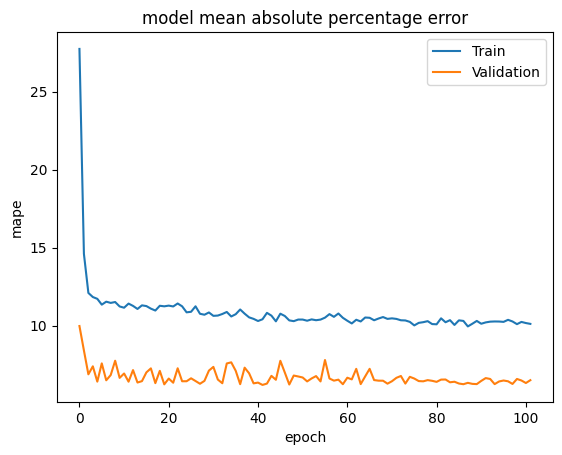

In [15]:
#Plot mape
plt.plot(model.history.history["mape"], label='Train')
plt.plot(model.history.history["val_mape"], label='Validation')
plt.legend()
plt.title('model mean absolute percentage error')
plt.ylabel('mape')
plt.xlabel('epoch')
#plt.ylim([35, 150])
#plt.xlim([0, 250])
plt.show

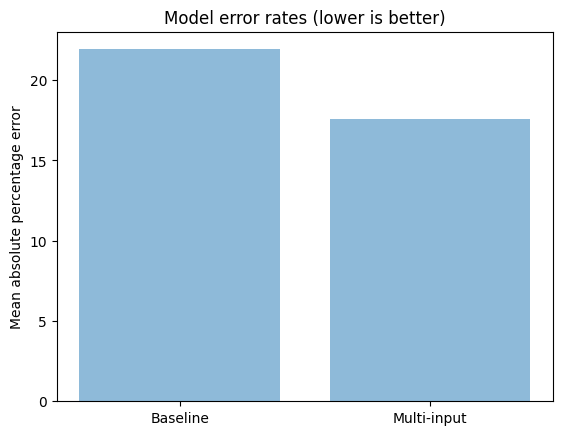

In [22]:
objects = ('Baseline', 'Multi-input')
y_pos = np.arange(len(objects))
performance = [21.92,17.57]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Mean absolute percentage error')
plt.title('Model error rates (lower is better)')

plt.show()